## ACP 166: Datos abiertos para ciudades resilientes
### Unidad 2: Datos abiertos para ciudades y clima
#### 5 de noviembre 2025

## Sección 1: Población en barrios populares

In [2]:
# install + import libraries

In [3]:
import requests
import geopandas as gpd
from io import StringIO
from shapely.geometry import box

In [4]:
# set CRS norms
USE_CRS = "EPSG:5348"  # POSGAR 2007 / Argentina 4
WEB_MERCATOR_CRS = "EPSG:3857"  # visualization
WGS84_CRS = "EPSG:4326"  # for API calls

### 1.1 Datos RENABAP

Make sure to talk about how I found these data!

In [5]:
RENABAP_URL = (
    "https://www.argentina.gob.ar/sites/default/files/renabap-2023-12-06.geojson"
)

response = requests.get(RENABAP_URL)
renabap = gpd.read_file(StringIO(response.text))
renabap_pba = renabap[renabap["provincia"] == "Buenos Aires"]
renabap_pba = renabap_pba.to_crs(USE_CRS)

In [6]:
renabap_pba.shape

(2065, 7)

In [7]:
renabap_pba.head()

,id_renabap,nombre_barrio,provincia,departamento,localidad,familias_aproximadas,geometry
0,1,Monterrey I,Buenos Aires,Pilar,Presidente Derqui,44,"MULTIPOLYGON (((6331563.369 6183392.384, 63315..."
1,2,Malvinas II,Buenos Aires,La Plata,José Melchor Romero,319,"MULTIPOLYGON (((6407555.589 6132750.136, 64078..."
2,3,Ferroviario,Buenos Aires,La Plata,Angel Etcheverry,146,"MULTIPOLYGON (((6401466.885 6122949.29, 640148..."
3,4,La Favelita,Buenos Aires,La Plata,Tolosa,134,"MULTIPOLYGON (((6410444.382 6137104.402, 64104..."
4,5,Casaca,Buenos Aires,La Plata,City Bell,22,"MULTIPOLYGON (((6402845.212 6137802.877, 64028..."


In [8]:
renabap_pba.describe()

,id_renabap,familias_aproximadas
count,2065.000000,2065.000000
mean,2082.995157,285.123002
std,2062.617169,513.854272
min,1.000000,9.000000
25%,554.000000,44.000000
50%,1146.000000,116.000000
75%,4324.000000,308.000000
max,6545.000000,8635.000000


<Axes: >

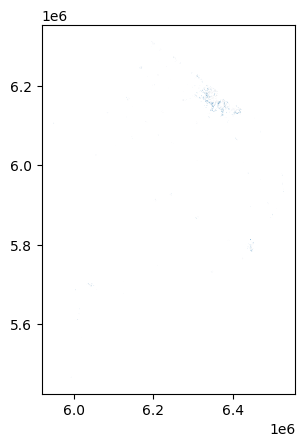

In [9]:
renabap_pba.plot()

In [10]:
import os
from owslib.wfs import WebFeatureService
from io import BytesIO

In [11]:
# Cargar partidos desde el servicio WFS de ARBA GeoServer
if os.path.exists("pba_partidos.geojson"):
    partidos = gpd.read_file("pba_partidos.geojson")
else:
    # Conectar al servicio WFS (Web Feature Service)
    wfs_url = "https://geo.arba.gov.ar/geoserver/idera/wfs"
    wfs = WebFeatureService(url=wfs_url, version="2.0.0")
    
    # Solicitar la capa de Departamento (partidos)
    response = wfs.getfeature(
        typename="idera:Departamento",
        srsname="EPSG:5347"  # CRS original
    )
    
    # Convertir respuesta WFS a GeoDataFrame
    partidos = gpd.read_file(BytesIO(response.read()))
    
    # Guardar en caché para uso futuro
    partidos.to_file("pba_partidos.geojson", driver="GeoJSON")

# Reproyectar al CRS de trabajo
partidos = partidos.to_crs(USE_CRS)

la_plata = partidos[partidos["fna"] == "Partido de La Plata"]

# Obtener la geometría principal y mantener solo el polígono más grande
# Esto elimina pequeñas islas que aparecen en los datos
la_plata = la_plata.copy()
main_geom = la_plata.geometry.iloc[0]
la_plata.loc[la_plata.index[0], "geometry"] = max(main_geom.geoms, key=lambda p: p.area)

In [12]:
renabap_la_plata = renabap_pba[
    renabap_pba.geometry.intersects(la_plata.union_all())
].copy()


<Axes: >

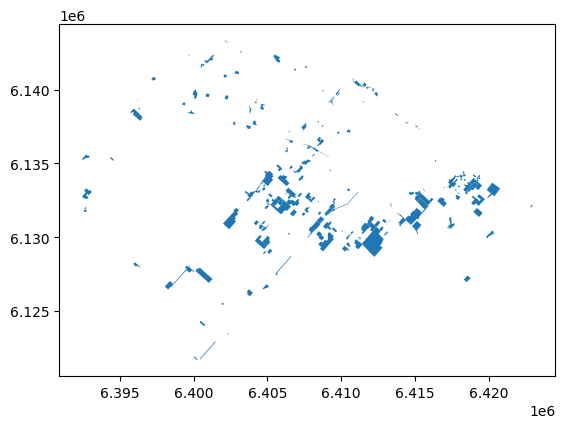

In [13]:
renabap_la_plata.plot()

In [14]:
renabap_la_plata.head()

,id_renabap,nombre_barrio,provincia,departamento,localidad,familias_aproximadas,geometry
1,2,Malvinas II,Buenos Aires,La Plata,José Melchor Romero,319,"MULTIPOLYGON (((6407555.589 6132750.136, 64078..."
2,3,Ferroviario,Buenos Aires,La Plata,Angel Etcheverry,146,"MULTIPOLYGON (((6401466.885 6122949.29, 640148..."
3,4,La Favelita,Buenos Aires,La Plata,Tolosa,134,"MULTIPOLYGON (((6410444.382 6137104.402, 64104..."
4,5,Casaca,Buenos Aires,La Plata,City Bell,22,"MULTIPOLYGON (((6402845.212 6137802.877, 64028..."
5,6,La Güemes,Buenos Aires,La Plata,Manuel B. Gonnet,13,"MULTIPOLYGON (((6404319.291 6139312.069, 64043..."


In [15]:
renabap_la_plata['familias_aproximadas'].describe()

count     167.000000
mean      203.131737
std       238.285607
min         9.000000
25%        46.000000
50%       132.000000
75%       252.000000
max      1551.000000
Name: familias_aproximadas, dtype: float64

array([[<Axes: title={'center': 'familias_aproximadas'}>]], dtype=object)

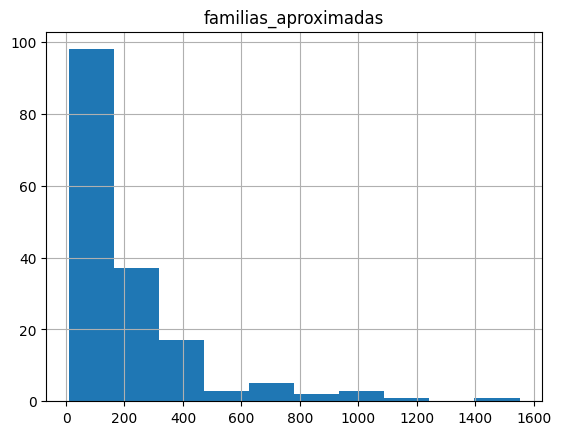

In [16]:
renabap_la_plata.hist('familias_aproximadas')

<Axes: >

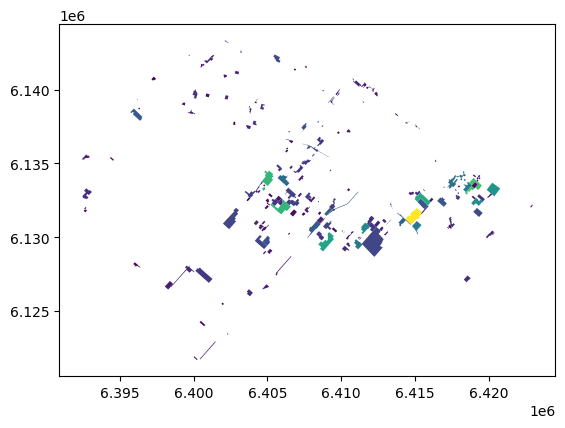

In [17]:
renabap_la_plata.plot('familias_aproximadas')

# add the la plata borders
# make sure there's a legend
# add a title

In [18]:
# import RENABAP data; explain what they are
# explore renabap data
# talk about metadata--how were they calculated?

### 1.2 Datos GHSL

In [19]:
import rioxarray as rio


In [20]:
# Import GHSL population data
ghsl_ruta = "/home/nissim/Downloads/spatial/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R14_C13/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R14_C13.tif"

ghsl = rio.open_rasterio(
    ghsl_ruta,
    chunks={"x": 2048, "y": 2048},
)

In [21]:
# Reproject to USE_CRS
ghsl = ghsl.rio.reproject(dst_crs=USE_CRS)

# Clip to La Plata boundaries
ghsl_clipped = ghsl.rio.clip(
    [la_plata.geometry.iloc[0]],
    from_disk=True,
)

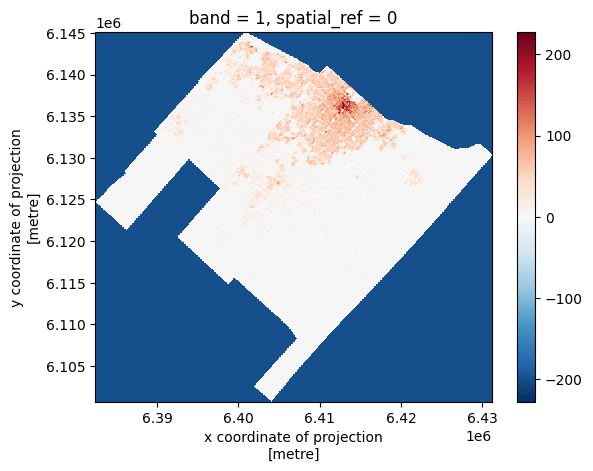

In [22]:
ghsl_clipped.plot()

In [23]:
import numpy as np
import matplotlib.pyplot as plt

GHSL Population Data Analysis (Fixed for No-Data):
  Original shape: (1, 13419, 16682)
  Clipped shape: (1, 543, 597)
  Valid pixels (excluding -200): 133232
  No-data pixels (-200): 190939
  Total population (valid only): 1162098

GHSL Population Statistics (Valid Data Only):
  Min: 0.00
  Max: 227.67
  Mean: 8.72
  Median: 0.00
  Std: 20.22

GHSL Population Percentiles:
  90th percentile: 39.80
  95th percentile: 57.39
  99th percentile: 84.46
  99.5th percentile: 101.18
  99.9th percentile: 150.08

Extreme outliers (>99.9th percentile): 133 pixels
  Threshold: 150.08
  Max value: 227.67


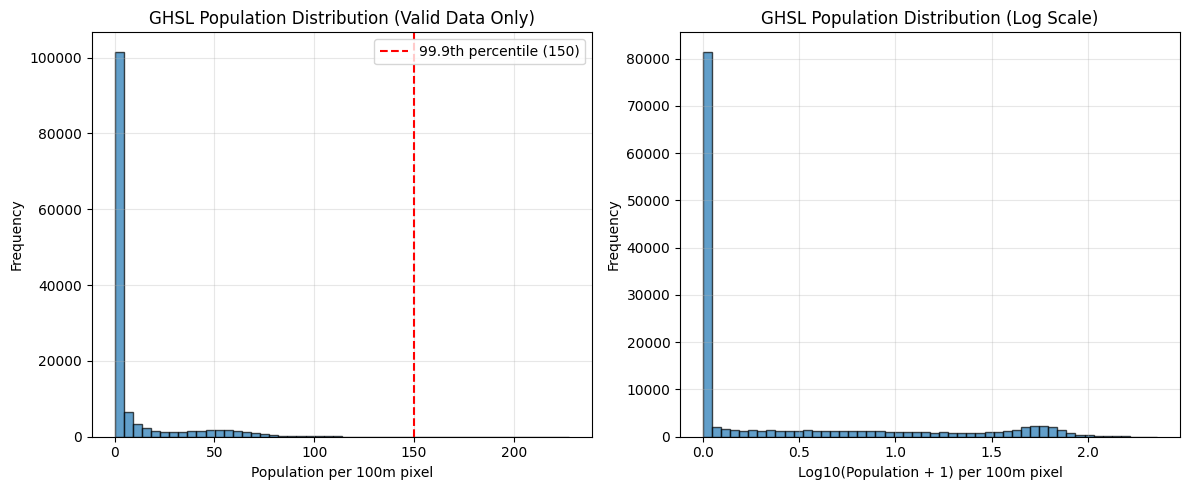


OUTLIER CORRECTION OPTIONS
Original total population (valid only): 1162098
Corrected (99.9th percentile cap): 1158507
Corrected (99th percentile cap): 1127245
Corrected (95th percentile cap): 1038423

Population reduction from capping:
  99.9th percentile: 0.31%
  99th percentile: 3.00%
  95th percentile: 10.64%

Recommendation: Use 99th percentile capping
  - Removes extreme outliers while preserving most data
  - Reduces total population by only 3.00%
  - Threshold: 84 people per 100m pixel
  - No-data values set to 0 for analysis


In [24]:
# =============================================================================
# IMPORT AND PROCESS GHSL POPULATION DATA (FIXED FOR NO-DATA)
# =============================================================================





# Properly handle no-data values (-200)
ghsl_values = ghsl_clipped.values[0]
valid_mask = ghsl_values > -200  # Exclude no-data values
ghsl_valid = ghsl_values[valid_mask]

print("GHSL Population Data Analysis (Fixed for No-Data):")
print(f"  Original shape: {ghsl.shape}")
print(f"  Clipped shape: {ghsl_clipped.shape}")
print(f"  Valid pixels (excluding -200): {np.sum(valid_mask)}")
print(f"  No-data pixels (-200): {np.sum(ghsl_values == -200)}")
print(f"  Total population (valid only): {np.sum(ghsl_valid):.0f}")

# =============================================================================
# OUTLIER ANALYSIS (FIXED)
# =============================================================================

print(f"\nGHSL Population Statistics (Valid Data Only):")
print(f"  Min: {ghsl_valid.min():.2f}")
print(f"  Max: {ghsl_valid.max():.2f}")
print(f"  Mean: {ghsl_valid.mean():.2f}")
print(f"  Median: {np.median(ghsl_valid):.2f}")
print(f"  Std: {ghsl_valid.std():.2f}")

# Calculate percentiles
percentiles = [90, 95, 99, 99.5, 99.9]
print(f"\nGHSL Population Percentiles:")
for p in percentiles:
    val = np.percentile(ghsl_valid, p)
    print(f"  {p}th percentile: {val:.2f}")

# Identify extreme outliers (beyond 99.9th percentile)
extreme_threshold = np.percentile(ghsl_valid, 99.9)
extreme_count = np.sum(ghsl_valid > extreme_threshold)
print(f"\nExtreme outliers (>99.9th percentile): {extreme_count} pixels")
print(f"  Threshold: {extreme_threshold:.2f}")
print(f"  Max value: {ghsl_valid.max():.2f}")

# Create histogram to visualize distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(ghsl_valid, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Population per 100m pixel')
plt.ylabel('Frequency')
plt.title('GHSL Population Distribution (Valid Data Only)')
plt.axvline(extreme_threshold, color='red', linestyle='--', label=f'99.9th percentile ({extreme_threshold:.0f})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Log scale for better visualization
plt.hist(np.log10(ghsl_valid + 1), bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Log10(Population + 1) per 100m pixel')
plt.ylabel('Frequency')
plt.title('GHSL Population Distribution (Log Scale)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# OUTLIER CORRECTION OPTIONS (FIXED)
# =============================================================================

print("\n" + "=" * 60)
print("OUTLIER CORRECTION OPTIONS")
print("=" * 60)

# Create corrected versions
ghsl_corrected_999 = ghsl_clipped.copy()
ghsl_corrected_999 = ghsl_corrected_999.where(ghsl_corrected_999 > -200, 0)  # Set no-data to 0
ghsl_corrected_999 = ghsl_corrected_999.where(ghsl_corrected_999 <= extreme_threshold, extreme_threshold)

ghsl_corrected_99 = ghsl_clipped.copy()
extreme_threshold_99 = np.percentile(ghsl_valid, 99)
ghsl_corrected_99 = ghsl_corrected_99.where(ghsl_corrected_99 > -200, 0)  # Set no-data to 0
ghsl_corrected_99 = ghsl_corrected_99.where(ghsl_corrected_99 <= extreme_threshold_99, extreme_threshold_99)

ghsl_corrected_95 = ghsl_clipped.copy()
extreme_threshold_95 = np.percentile(ghsl_valid, 95)
ghsl_corrected_95 = ghsl_corrected_95.where(ghsl_corrected_95 > -200, 0)  # Set no-data to 0
ghsl_corrected_95 = ghsl_corrected_95.where(ghsl_corrected_95 <= extreme_threshold_95, extreme_threshold_95)

print(f"Original total population (valid only): {np.sum(ghsl_valid):.0f}")
print(f"Corrected (99.9th percentile cap): {np.sum(ghsl_corrected_999.values[0]):.0f}")
print(f"Corrected (99th percentile cap): {np.sum(ghsl_corrected_99.values[0]):.0f}")
print(f"Corrected (95th percentile cap): {np.sum(ghsl_corrected_95.values[0]):.0f}")

# Show impact of capping
print(f"\nPopulation reduction from capping:")
print(f"  99.9th percentile: {((np.sum(ghsl_valid) - np.sum(ghsl_corrected_999.values[0])) / np.sum(ghsl_valid) * 100):.2f}%")
print(f"  99th percentile: {((np.sum(ghsl_valid) - np.sum(ghsl_corrected_99.values[0])) / np.sum(ghsl_valid) * 100):.2f}%")
print(f"  95th percentile: {((np.sum(ghsl_valid) - np.sum(ghsl_corrected_95.values[0])) / np.sum(ghsl_valid) * 100):.2f}%")

# Recommend a capping strategy
print(f"\nRecommendation: Use 99th percentile capping")
print(f"  - Removes extreme outliers while preserving most data")
print(f"  - Reduces total population by only {((np.sum(ghsl_valid) - np.sum(ghsl_corrected_99.values[0])) / np.sum(ghsl_valid) * 100):.2f}%")
print(f"  - Threshold: {extreme_threshold_99:.0f} people per 100m pixel")
print(f"  - No-data values set to 0 for analysis")

In [25]:
import rasterstats

In [26]:

# Set no-data values to 0, keep all valid population values
ghsl_final = ghsl_clipped.where(ghsl_clipped > -200, 0)

# Extract geometries for zonal statistics
barrio_geometries = [geom for geom in renabap_la_plata.geometry]

# Calculate zonal statistics for GHSL population
ghsl_stats = rasterstats.zonal_stats(
    barrio_geometries,
    ghsl_final.values[0],
    affine=ghsl_final.rio.transform(),
    stats=["sum"],
    nodata=0,
)

# Add GHSL population sums to barrios_populares
ghsl_sums = [stat["sum"] if stat["sum"] is not None else 0 for stat in ghsl_stats]
renabap_la_plata["ghsl_population_sum"] = ghsl_sums

array([[<Axes: title={'center': 'ghsl_population_sum'}>]], dtype=object)

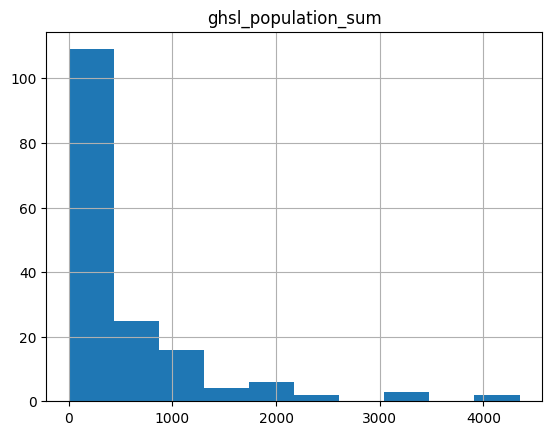

In [27]:
renabap_la_plata.hist('ghsl_population_sum')

In [28]:
renabap_la_plata.describe()

,id_renabap,familias_aproximadas,ghsl_population_sum
count,167.000000,167.000000,167.000000
mean,1185.185629,203.131737,533.430825
std,1765.065218,238.285607,762.901664
min,2.000000,9.000000,0.000000
25%,69.000000,46.000000,81.442774
50%,627.000000,132.000000,252.472338
75%,1075.500000,252.000000,731.548264
max,6545.000000,1551.000000,4347.947598


### 1.3 Datos de edificaciones

In [29]:
BASE_PATH = "/home/nissim/Documents/dev/fulbright/ciut-riesgo"
BUILDINGS_PATH = f"{BASE_PATH}/notebooks/buildings_filtered.parquet"

In [30]:
import sys
print(sys.executable)

/home/nissim/Documents/dev/datos-escala-humana/.venv/bin/python


In [31]:
# if os.path.exists(BUILDINGS_PATH):
#     buildings = gpd.read_parquet(BUILDINGS_PATH)
# else:
#     buildings = fetch_buildings(la_plata.buffer(500))

buildings = gpd.read_parquet(BUILDINGS_PATH)

la_plata_buffered = la_plata.union_all().buffer(500)
buildings_proj = buildings.to_crs(USE_CRS)
buildings_proj = buildings_proj[buildings_proj.geometry.intersects(la_plata_buffered)]

In [32]:
buildings_proj.shape

(650812, 10)

In [33]:
buildings_filtered = buildings_proj[buildings_proj['area_in_meters'] > 15] # filter out really small buildings

In [34]:
buildings_filtered.shape

(601283, 10)

In [35]:
# =============================================================================
# SPATIAL INTERSECTION: Sum buildings per barrio popular
# =============================================================================

# Perform spatial join to find which buildings intersect with each barrio
buildings_in_barrios = gpd.sjoin(
   buildings_filtered,  # Use filtered buildings
    renabap_la_plata[["id_renabap", "geometry"]], 
    how="inner", 
    predicate="within"
)

# Count buildings per barrio
buildings_per_barrio = buildings_in_barrios.groupby("id_renabap").size().reset_index(name="buildings_count")

# Merge back to renabap_la_plata
renabap_la_plata = renabap_la_plata.merge(
    buildings_per_barrio, 
    on="id_renabap", 
    how="left"
)

# Fill NaN values with 0 for barrios with no buildings
renabap_la_plata["buildings_count"] = renabap_la_plata["buildings_count"].fillna(0).astype(int)


In [36]:
renabap_la_plata.describe()


,id_renabap,familias_aproximadas,ghsl_population_sum,buildings_count
count,167.000000,167.000000,167.000000,167.000000
mean,1185.185629,203.131737,533.430825,384.047904
std,1765.065218,238.285607,762.901664,507.250809
min,2.000000,9.000000,0.000000,9.000000
25%,69.000000,46.000000,81.442774,84.000000
50%,627.000000,132.000000,252.472338,212.000000
75%,1075.500000,252.000000,731.548264,480.500000
max,6545.000000,1551.000000,4347.947598,3175.000000


### 1.4 Comparación de datos

Compare estimated families and GHSL pop to building count. takeaways are:

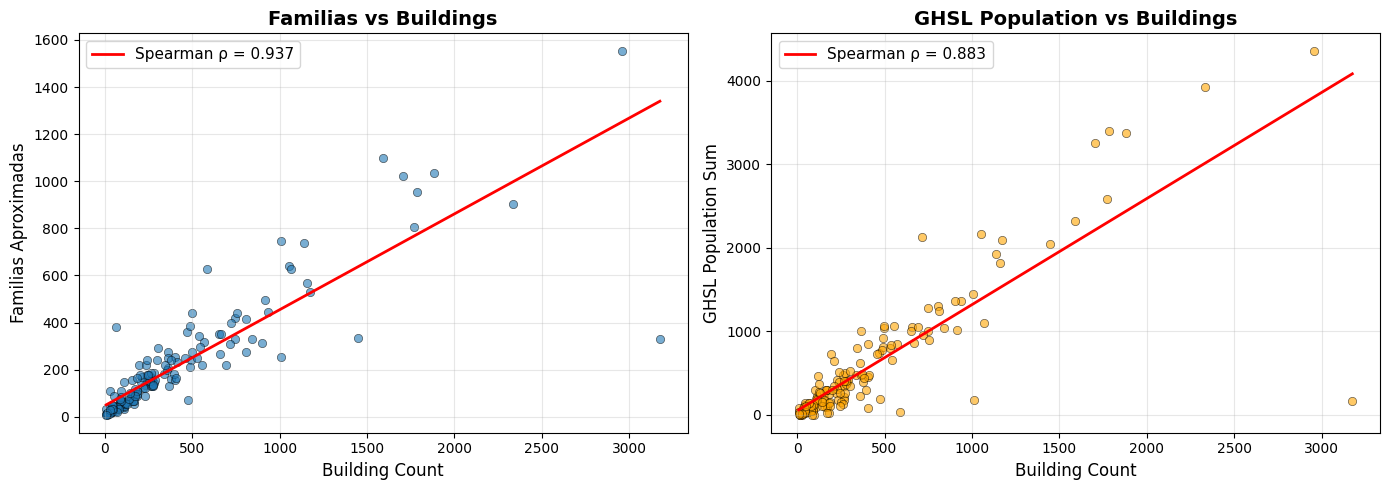

Familias vs Buildings:
  Spearman ρ = 0.9368
  p-value = 3.80e-77

GHSL Population vs Buildings:
  Spearman ρ = 0.8833
  p-value = 3.51e-56


In [37]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Families vs Buildings
ax1 = axes[0]
ax1.scatter(renabap_la_plata['buildings_count'], 
            renabap_la_plata['familias_aproximadas'],
            alpha=0.6, edgecolors='k', linewidth=0.5)

# Spearman correlation for families vs buildings
rho1, p_value1 = stats.spearmanr(
    renabap_la_plata['buildings_count'], 
    renabap_la_plata['familias_aproximadas']
)

# Add regression line for reference (still linear)
slope1, intercept1 = np.polyfit(
    renabap_la_plata['buildings_count'], 
    renabap_la_plata['familias_aproximadas'], 
    1
)
x1 = np.array([renabap_la_plata['buildings_count'].min(), 
               renabap_la_plata['buildings_count'].max()])
ax1.plot(x1, intercept1 + slope1*x1, 'r-', linewidth=2, 
         label=f'Spearman ρ = {rho1:.3f}')

ax1.set_xlabel('Building Count', fontsize=12)
ax1.set_ylabel('Familias Aproximadas', fontsize=12)
ax1.set_title('Familias vs Buildings', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Plot 2: GHSL Population vs Buildings
ax2 = axes[1]
ax2.scatter(renabap_la_plata['buildings_count'], 
            renabap_la_plata['ghsl_population_sum'],
            alpha=0.6, edgecolors='k', linewidth=0.5, color='orange')

# Spearman correlation for GHSL vs buildings
rho2, p_value2 = stats.spearmanr(
    renabap_la_plata['buildings_count'], 
    renabap_la_plata['ghsl_population_sum']
)

# Add regression line for reference
slope2, intercept2 = np.polyfit(
    renabap_la_plata['buildings_count'], 
    renabap_la_plata['ghsl_population_sum'], 
    1
)
x2 = np.array([renabap_la_plata['buildings_count'].min(), 
               renabap_la_plata['buildings_count'].max()])
ax2.plot(x2, intercept2 + slope2*x2, 'r-', linewidth=2, 
         label=f'Spearman ρ = {rho2:.3f}')

ax2.set_xlabel('Building Count', fontsize=12)
ax2.set_ylabel('GHSL Population Sum', fontsize=12)
ax2.set_title('GHSL Population vs Buildings', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed stats
print(f"Familias vs Buildings:")
print(f"  Spearman ρ = {rho1:.4f}")
print(f"  p-value = {p_value1:.2e}\n")

print(f"GHSL Population vs Buildings:")
print(f"  Spearman ρ = {rho2:.4f}")
print(f"  p-value = {p_value2:.2e}")

In [38]:
print(renabap_la_plata['familias_aproximadas'].sum())

33923


In [39]:
print(renabap_la_plata['ghsl_population_sum'].sum())

89082.94773741066


In [40]:
print(renabap_la_plata['buildings_count'].sum())

64136


count    167.000000
mean       1.829411
std        0.950827
min        0.169713
25%        1.369318
50%        1.765625
75%        2.084886
max        9.621212
Name: buildings_per_family, dtype: float64


<Axes: >

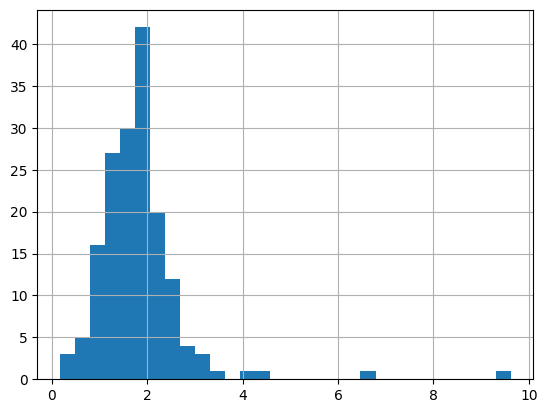

In [41]:
renabap_la_plata['buildings_per_family'] = (
    renabap_la_plata['buildings_count'] / renabap_la_plata['familias_aproximadas']
)

print(renabap_la_plata['buildings_per_family'].describe())
renabap_la_plata['buildings_per_family'].hist(bins=30)

## Sección 2: Peligro de inundaciones

In [42]:
# datos de hidráulica
ruta_peligro = "/home/nissim/Documents/dev/fulbright/ciut-riesgo/notebooks/data/peligro_raster_10m.tif"
peligro_xarray = rio.open_rasterio(ruta_peligro)

# clip to la plata
# mask out 0 values (nodata/muy bajo peligro)

peligro_4326 = peligro_xarray.rio.reproject("EPSG:4326")

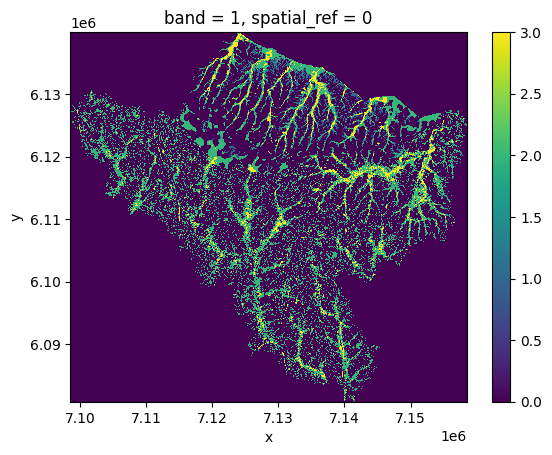

In [55]:
peligro_xarray.plot()

In [43]:
# datos de HAND
hand_path = "/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/la_plata/final/hand-la-plata-100m.tif"
hand_xarray = rio.open_rasterio(hand_path)

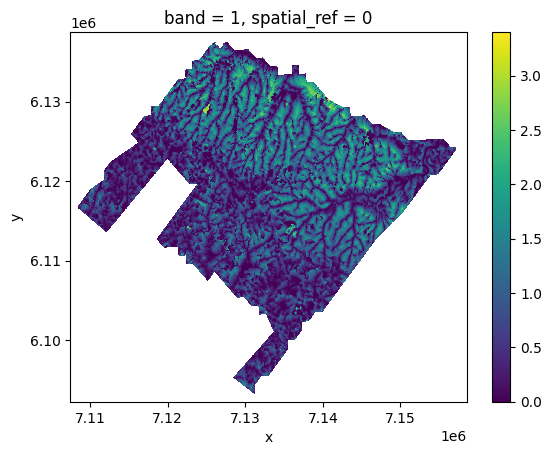

In [44]:
hand_xarray.plot()

In [47]:
hand_cat_xarray = hand_xarray.copy()
hand_cat_xarray.values = ((hand_xarray >= 0.5).astype(float) + 
                          (hand_xarray >= 2).astype(float) + 
                          (hand_xarray >= 5).astype(float))
hand_cat_xarray = hand_cat_xarray.where(hand_xarray.notnull())

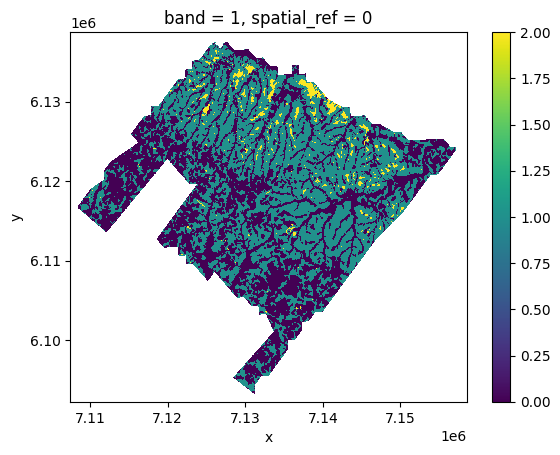

In [48]:
hand_cat_xarray.plot()

In [ ]:
# datos de JRC


/tmp/ipykernel_71595/1928156875.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis')



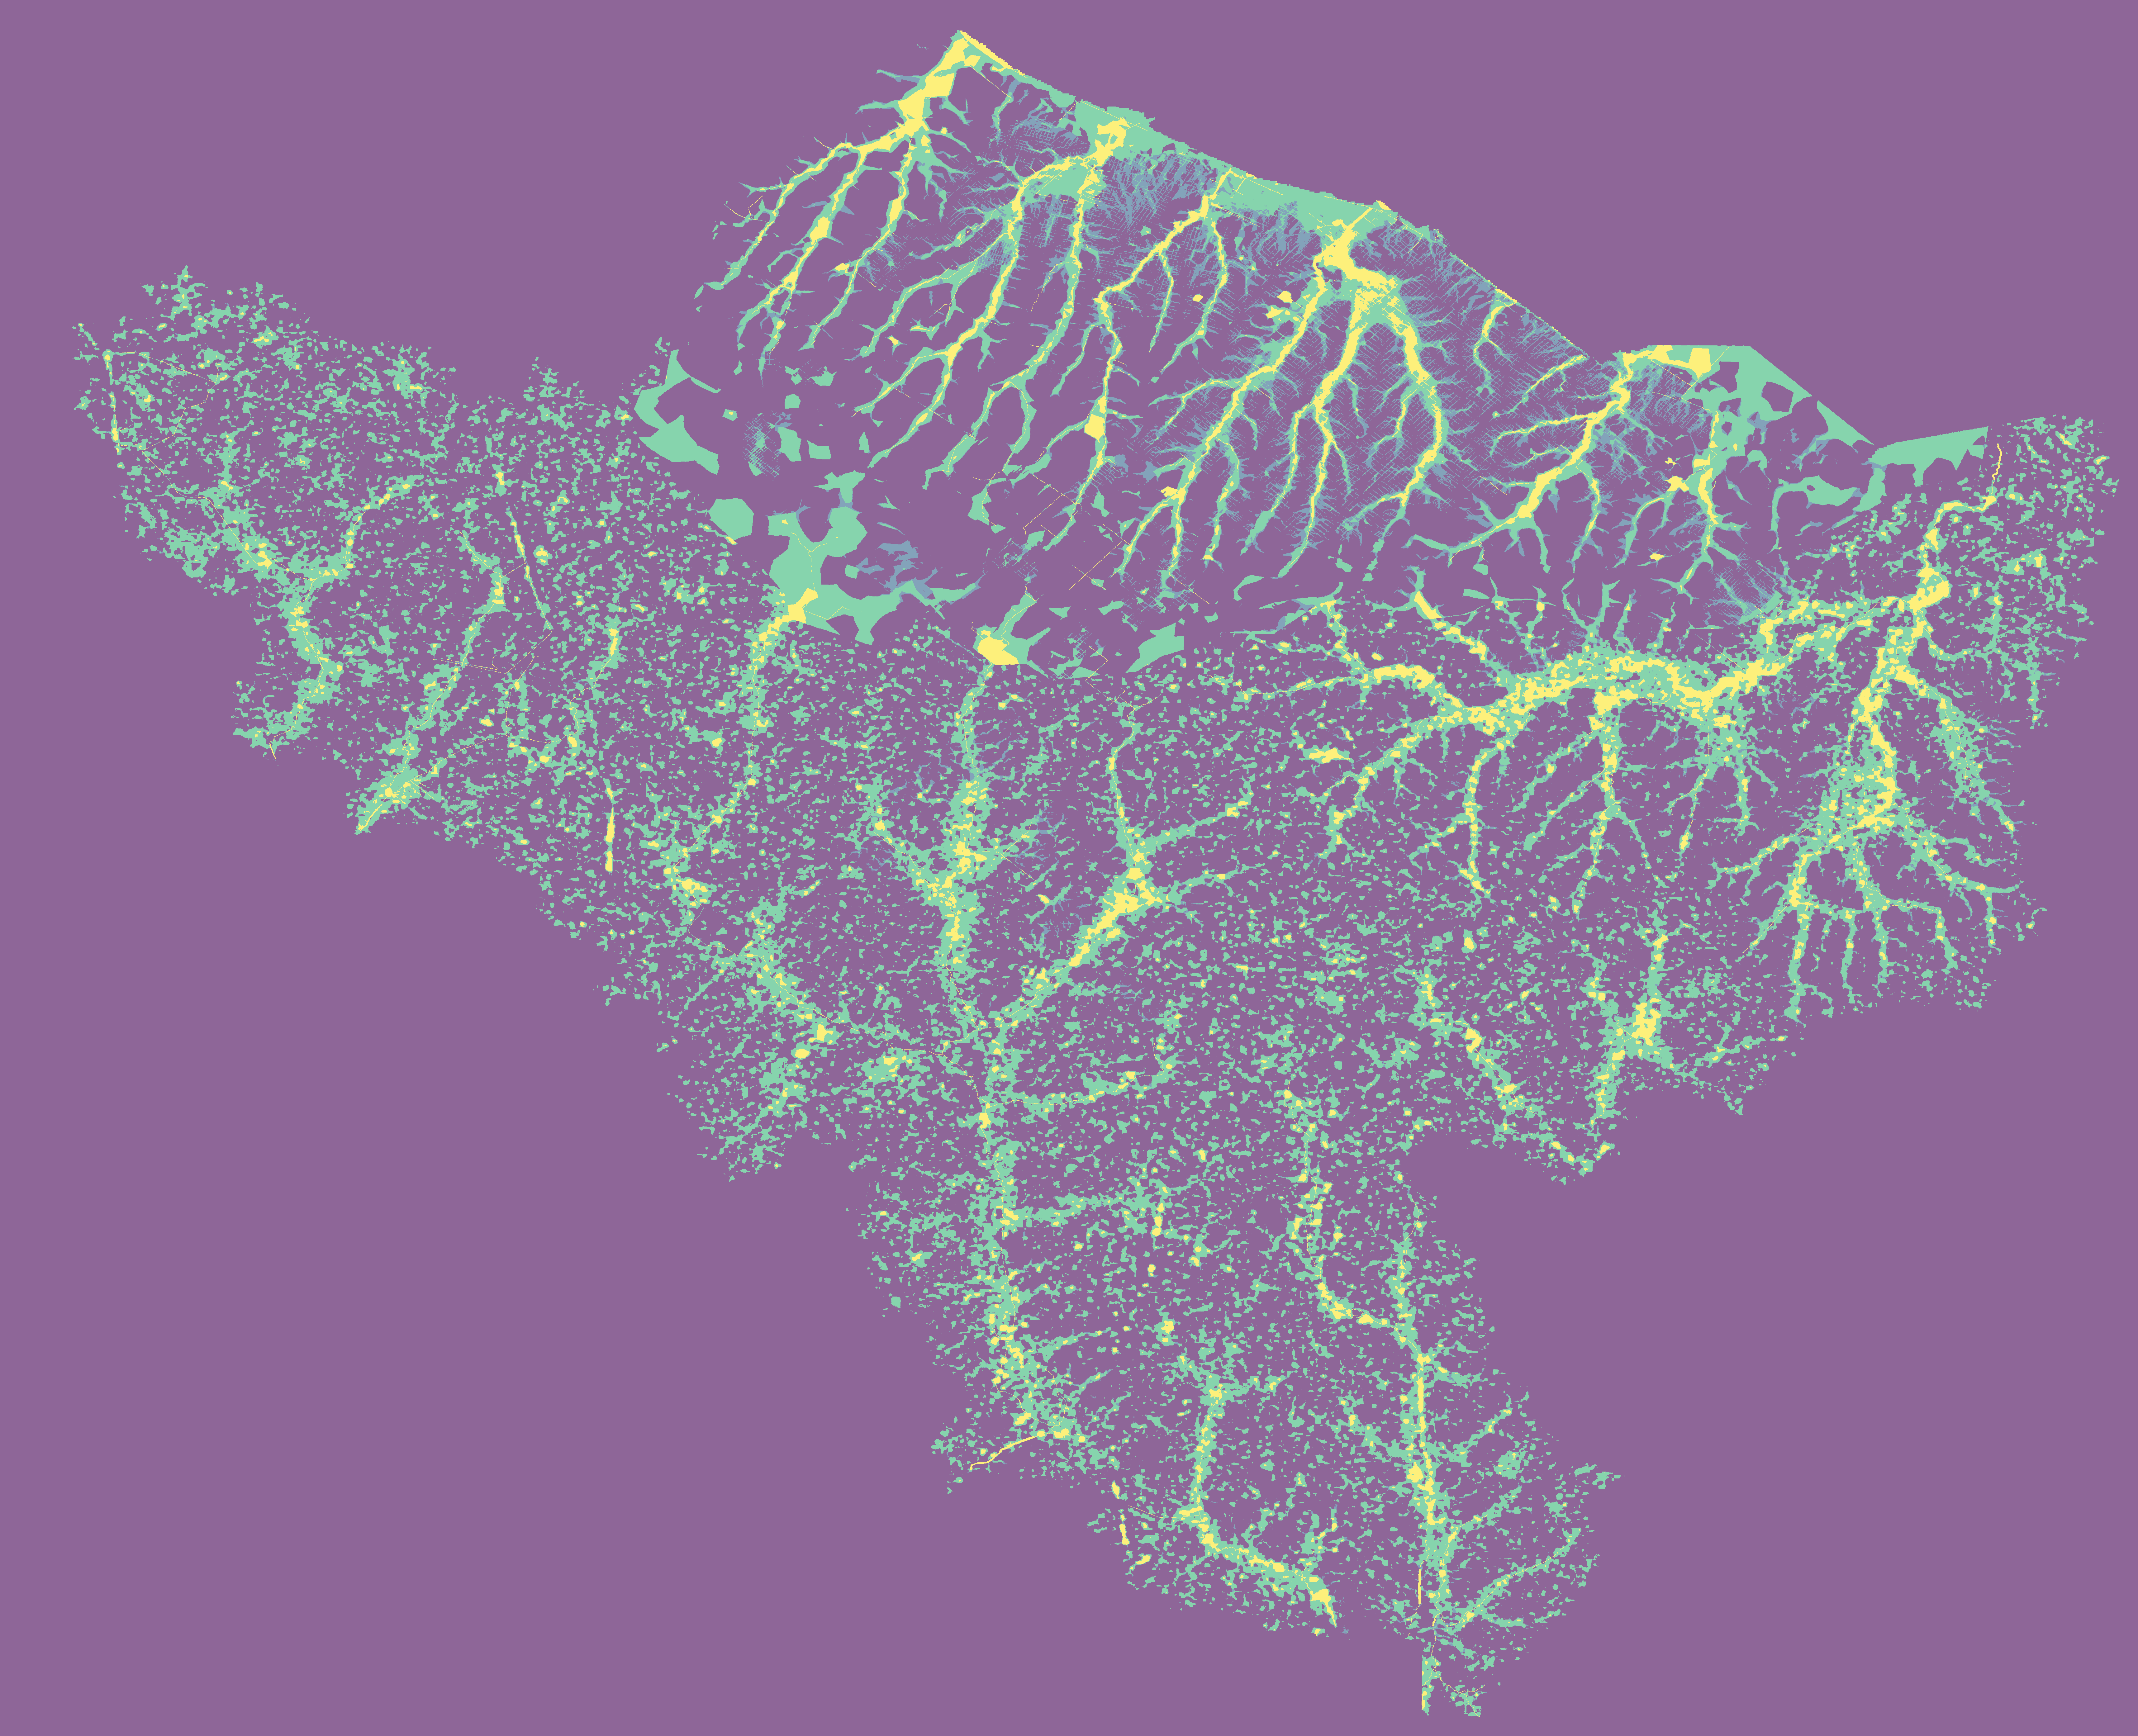
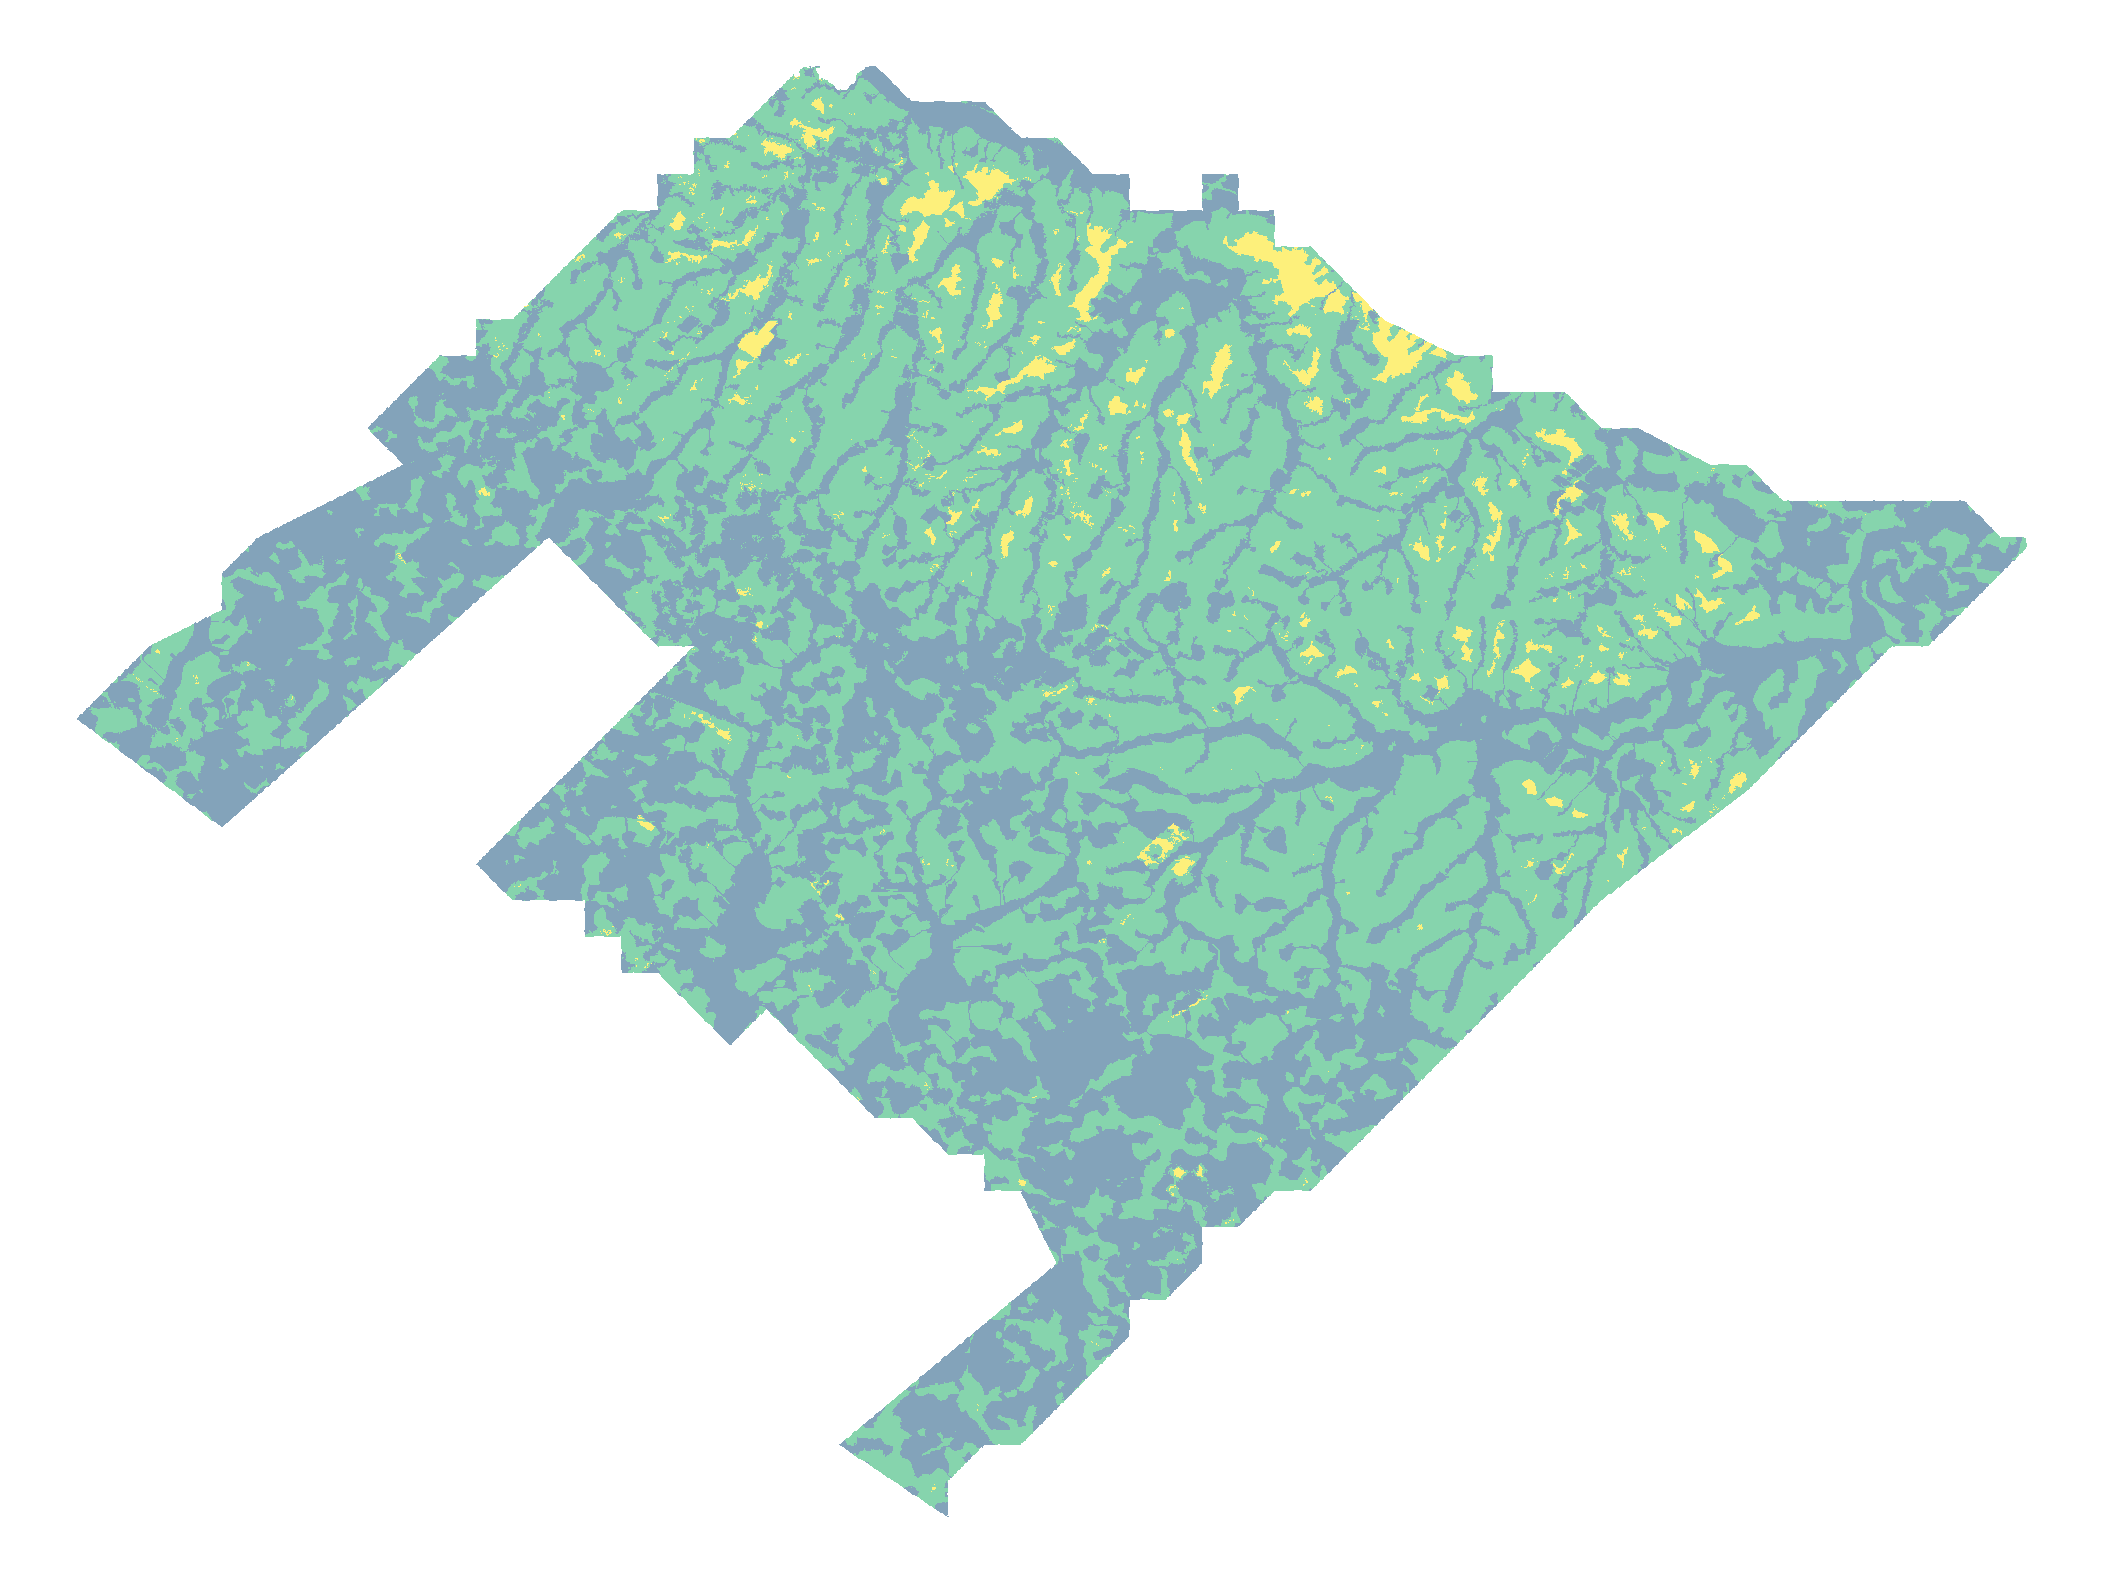

In [58]:
import folium
from folium import raster_layers
import numpy as np
from matplotlib import cm

# Create base map
m = folium.Map(
    location=[hand_cat_4326.y.mean().item(), hand_cat_4326.x.mean().item()],
    zoom_start=10,
    tiles='OpenStreetMap'
)

# Get viridis colors for indices 0-3
viridis = cm.get_cmap('viridis')
viridis_colors = (viridis(np.array([0, 0.33, 0.67, 1.0]))[:, :3] * 255).astype(np.uint8)

# Add Peligro layer (values: 0, 1, 2, 3 → colors: 0, 1, 2, 3)
peligro_data = peligro_4326.values.squeeze()
peligro_rgb = np.zeros((*peligro_data.shape, 4), dtype=np.uint8)

mask_0 = peligro_data == 0
mask_1 = peligro_data == 1
mask_2 = peligro_data == 2
mask_3 = peligro_data == 3

peligro_rgb[mask_0, :3] = viridis_colors[0]
peligro_rgb[mask_1, :3] = viridis_colors[1]
peligro_rgb[mask_2, :3] = viridis_colors[2]
peligro_rgb[mask_3, :3] = viridis_colors[3]
peligro_rgb[~np.isnan(peligro_data), 3] = 153

folium.raster_layers.ImageOverlay(
    image=peligro_rgb,
    bounds=[[peligro_4326.y.min().item(), peligro_4326.x.min().item()],
            [peligro_4326.y.max().item(), peligro_4326.x.max().item()]],
    opacity=0.8,
    name='Peligro'
).add_to(m)

# Add HAND layer (values: 0, 1, 2 → colors: 1, 2, 3)
hand_data = hand_cat_4326.values.squeeze()
hand_rgb = np.zeros((*hand_data.shape, 4), dtype=np.uint8)

hand_rgb[hand_data == 0, :3] = viridis_colors[1]  # Same as Peligro 1
hand_rgb[hand_data == 1, :3] = viridis_colors[2]  # Same as Peligro 2
hand_rgb[hand_data == 2, :3] = viridis_colors[3]  # Same as Peligro 3
hand_rgb[~np.isnan(hand_data), 3] = 153

folium.raster_layers.ImageOverlay(
    image=hand_rgb,
    bounds=[[hand_cat_4326.y.min().item(), hand_cat_4326.x.min().item()],
            [hand_cat_4326.y.max().item(), hand_cat_4326.x.max().item()]],
    opacity=0.8,
    name='HAND Categorizado'
).add_to(m)

folium.LayerControl().add_to(m)
m